## Evaluation Metric

In [1]:
import numpy as np
from scipy.optimize import linear_sum_assignment
import math

In [2]:
class Line(object):
    def __init__(self, coordinates=[0, 0, 1, 1]):
        """
        coordinates: [y0, x0, y1, x1]

        """
        coordinates[0], coordinates[1] = coordinates[1], coordinates[0]
        coordinates[2], coordinates[3] = coordinates[3], coordinates[2]
        assert isinstance(coordinates, list)
        assert len(coordinates) == 4
        assert coordinates[0]!=coordinates[2] or coordinates[1]!=coordinates[3]
        self.__coordinates = coordinates

    @property
    def coord(self):
        return self.__coordinates

    @property
    def length(self):
        start = np.array(self.coord[:2])
        end = np.array(self.coord[2::])
        return np.sqrt(((start - end) ** 2).sum())

    def angle(self):
        y0, x0, y1, x1 = self.coord
        if x0 == x1:
            return -np.pi / 2
        return np.arctan((y0-y1) / (x0-x1))

    def rescale(self, rh, rw):
        coor = np.array(self.__coordinates)
        r = np.array([rh, rw, rh, rw])
        self.__coordinates = np.round(coor * r).astype(np.int).tolist()

    def __repr__(self):
        return str(self.coord)

In [3]:
def sa_metric(angle_p, angle_g):
    d_angle = np.abs(angle_p - angle_g)
    d_angle = min(d_angle, np.pi - d_angle)
    d_angle = d_angle * 2 / np.pi
    return max(0, (1 - d_angle)) ** 2

def se_metric(coord_p, coord_g, size=(512, 512)):
    c_p = [(coord_p[0] + coord_p[2]) / 2, (coord_p[1] + coord_p[3]) / 2]
    c_g = [(coord_g[0] + coord_g[2]) / 2, (coord_g[1] + coord_g[3]) / 2]
    d_coord = np.abs(c_p[0] - c_g[0])**2 + np.abs(c_p[1] - c_g[1])**2
    d_coord = np.sqrt(d_coord) / max(size[0], size[1])
    return max(0, (1 - d_coord)) ** 2
    
def EA_metric(l_pred, l_gt, size=(512, 512)):
    se = se_metric(l_pred.coord, l_gt.coord, size=size)
    sa = sa_metric(l_pred.angle(), l_gt.angle())
    return sa * se

In [4]:
def length_difference(p_coord, g_coord):
    p_y0, p_x0, p_y1, p_x1 = p_coord
    g_y0, g_x0, g_y1, g_x1 = g_coord

    norm_gt = np.sqrt(g_y0**2 + g_x0**2 + g_y1**2 + g_x1**2)
    norm_pd = np.sqrt(p_y0**2 + p_x0**2 + p_y1**2 + p_x1**2)

    norm_factor = np.sqrt(norm_gt**2 + norm_pd**2)

    dist1 = math.sqrt((g_x1 - p_x1) ** 2 + (g_y1 - p_y1) ** 2)
    dist2 = math.sqrt((g_x0 - p_x0) ** 2 + (g_y0 - p_y0) ** 2)
    diff1 = dist1 + dist2
    norm_diff1 = diff1 / norm_factor

    dist3 = math.sqrt((g_x1 - p_x0) ** 2 + (g_y1 - p_y0) ** 2)
    dist4 = math.sqrt((g_x0 - p_x1) ** 2 + (g_y0 - p_y1) ** 2)
    diff2 = dist3 + dist4
    norm_diff2 = diff2 / norm_factor

    len_diff = min(norm_diff1, norm_diff2)

    return len_diff

In [5]:
def build_graph(p_lines, g_lines, threshold):
    prediction_len = len(p_lines)
    gt_len = len(g_lines)
    G = np.zeros((prediction_len, gt_len))
    for i in range(prediction_len):
        for j in range(gt_len):
            if EA_metric(p_lines[i], g_lines[j]) >= threshold:
                G[i][j] = 1
    return G

In [6]:
def calculate_tp_fp_fn(b_points, gt_coords, thresh=0.90):
    p_lines = []
    g_lines = []
    for points in b_points:
        if len(points) == 0:
            continue 
        if points[0] == points[2] and points[1] == points[3]:
            continue 
        else:
            p_lines.append(Line(list(points)))
    
    for points in gt_coords:
        if len(points) == 0:
            continue
        if points[0] == points[2] and points[1] == points[3]:
            continue 
        else:
            g_lines.append(Line(list(points)))

    avg_length_difference = 0

    G = build_graph(p_lines, g_lines, thresh)

    row_ind, col_ind = linear_sum_assignment(-G)

    pair_nums = G[row_ind, col_ind].sum()

    tp = pair_nums
    fp = len(p_lines) - pair_nums
    fn = len(g_lines) - pair_nums

    length_differences = []
    for i, j in zip(row_ind, col_ind):  # Iterate over the matched indices
        if G[i, j] == 1:  # Ensure that this pair was actually matched
            p_coord = p_lines[i].coord
            g_coord = g_lines[j].coord
            len_diff = length_difference(p_coord, g_coord)
            length_differences.append(len_diff)

    if len(length_differences) > 0:
        avg_length_difference = np.mean(length_differences)

    return tp, fp, fn, avg_length_difference

## Evaluation

In [26]:
import rasterio
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
import glob
from rasterio.merge import merge
from skimage import measure

In [8]:
curr_path = os.getcwd()

print(curr_path)

D:\Masters\OVGU\VII_Semester\Thesis\jupyter_notebooks


In [20]:
tile_dir = os.path.join(curr_path, 'predictions\\xception-71-baseline')

print(tile_dir)

D:\Masters\OVGU\VII_Semester\Thesis\jupyter_notebooks\predictions\xception-71-baseline


In [21]:
file_names = os.listdir(tile_dir)

In [22]:
coord_dir = os.path.join(curr_path, 'Data\coordinates')
print(coord_dir)

D:\Masters\OVGU\VII_Semester\Thesis\jupyter_notebooks\Data\coordinates


In [23]:
tp_total= 0
fp_total= 0
fn_total = 0
len_diffs = []

In [27]:
for tif_file in file_names:
    file_path = os.path.join(tile_dir, tif_file)

    with rasterio.open(file_path) as src:
        image = src.read(1)
        meta = src.meta
        transform = src.transform

    min_val = np.min(image)
    max_val = np.max(image)
    
    if max_val == min_val:
        # Handle the case where all values are the same (e.g., a constant image)
        tile_normalized = np.zeros_like(image, dtype=np.float32)
    else:
        # Normalize to range [0, 1]
        tile_normalized = (image - min_val) / (max_val - min_val)

    # Convert normalized image to uint8 (scale to [0, 255])
    tile_uint8 = (tile_normalized * 255).astype(np.uint8)
    
    tile_lines = cv2.HoughLinesP(tile_uint8, 1, np.pi / 180, threshold=50, minLineLength=10, maxLineGap=15)

    blank_image = np.zeros((512, 512), dtype=np.uint8)

    if tile_lines is not None:
        for line in tile_lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(blank_image, (x1, y1), (x2, y2), 255, 2)  # White lines

    tile_edges = cv2.Canny(blank_image, threshold1=100, threshold2=200)
    
    tile_contours, _ = cv2.findContours(tile_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw the contours onto a new image
    tile_lines = np.zeros_like(tile_uint8)
    contour_image = cv2.drawContours(tile_lines, tile_contours, -1, (255, 255, 255), thickness=5)

    # Define a kernel
    kernel = np.ones((15,15), np.uint8)
    
    # Apply dilation
    dilated_edges = cv2.dilate(contour_image, kernel, iterations=1)
    
    binary_image = dilated_edges > 0
    
    skeleton = skeletonize(binary_image)

    labeled_skeleton, num_labels = measure.label(skeleton, return_num=True, connectivity=2)

    line_coordinates = []
    
    for label in range(1, num_labels + 1):
        component_mask = (labeled_skeleton == label)
        endpoints = []
        
        # Loop through skeleton and find endpoints
        for y in range(1, component_mask.shape[0] - 1):
            for x in range(1, component_mask.shape[1] - 1):
                if component_mask[y, x]:
                    # Check the 8-neighborhood
                    neighbors = component_mask[y-1:y+2, x-1:x+2]
                    if np.sum(neighbors) == 2:  # Exactly one neighbor means it's an endpoint
                        endpoints.append((x, y))

        if len(endpoints) == 2:
            start = endpoints[0]
            end = endpoints[1]
            line_coordinates.append([start[0], start[1], end[0], end[1]])

    # Get the base name without extension and split by '_'
    index, coord1, coord2 = os.path.splitext(os.path.basename(tif_file))[0].split('_')[1:4]
    
    # Create the output filename (with matching indices)
    file_name = f"Coo_{index}_{coord1}_{coord2}_coo.txt"
    
    # Join the path
    coord_path = os.path.join(coord_dir, file_name)
    
    ground_truth_coord = []
    
    with open(coord_path, 'r') as file:
        for line in file:
            line = line.strip()    
            coordinates = [float(x) for x in line.split(',')]    
            ground_truth_coord.append(coordinates)

    if not line_coordinates and not ground_truth_coord:
        pass  # No detected lines and no ground truth lines
    elif not line_coordinates and ground_truth_coord:
        fn_total += len(ground_truth_coord)  # All ground truth lines are false negatives
    elif line_coordinates and not ground_truth_coord:
        fp_total += len(line_coordinates)  # All detected lines are false positives
    else:
        tp, fp, fn, avg_len_diff = calculate_tp_fp_fn(line_coordinates, ground_truth_coord, 0.70)
        
        tp_total += tp
        fp_total += fp
        fn_total += fn
        len_diffs.append(avg_len_diff)

    blank_image_2 = np.zeros((512, 512), dtype=np.uint8)

    if line_coordinates is not None:
        for lines in line_coordinates:
            x1, y1, x2, y2 = lines
            cv2.line(blank_image_2, (x1, y1), (x2, y2), 255, 2)  # White lines                
 
    meta.update(dtype=rasterio.uint8, count=1)

    output_tif_path = os.path.join(curr_path, 'Data\pht_output_tiles_11', tif_file)
    
    with rasterio.open(output_tif_path, 'w', **meta) as dst:
        dst.write(blank_image_2, 1)

In [28]:
precision = tp_total / (tp_total + fp_total) if tp_total + fp_total != 0 else 0
recall = tp_total / (tp_total + fn_total) if tp_total + fn_total != 0 else 0
f1_score = 2 * precision * recall / (precision + recall) if precision + recall != 0 else 0

valid_len_diffs = [x for x in len_diffs if x is not None and x != []]

if valid_len_diffs: 
    overall_average = sum(valid_len_diffs) / len(valid_len_diffs)
else:
    overall_average = 0

C:\Users\koner\AppData\Local\Temp\ipykernel_45092\1914830568.py:5: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  valid_len_diffs = [x for x in len_diffs if x is not None and x != []]


In [29]:
print('Precision', precision)
print('Recall', recall)
print('F1_score', f1_score)
print('Length_Difference', overall_average)

Precision 0.4346696362286563
Recall 0.2690098782448886
F1_score 0.3323400028380871
Length_Difference 0.0


In [ ]:
len_diffs

In [ ]:
pht_tiles_dir = os.path.join(curr_path, 'Data\pht_output_tiles_11')

print(pht_tiles_dir)

In [101]:
# Search pattern to find all .tif files
search_criteria = "*.tif"
q = os.path.join(pht_tiles_dir, search_criteria)
tile_files = glob.glob(q)

In [102]:
# Open all the files and append to a list
src_files_to_mosaic = []
for fp in tile_files:
    src = rasterio.open(fp)
    src_files_to_mosaic.append(src)

In [103]:
# Merge the individual tiles
mosaic, out_trans = merge(src_files_to_mosaic)

In [104]:
# Update metadata
out_meta = src.meta.copy()

In [105]:
# Update to new dimensions, transform, and CRS
out_meta.update({
    "driver": "GTiff",
    "height": mosaic.shape[1],
    "width": mosaic.shape[2],
    "transform": out_trans,
    "crs": src.crs
})

In [106]:
# Write the merged file to disk
output_fp = os.path.join(curr_path, "Data\Test_Data_Pred\\test_merged\\skel_test_merged.tif")
with rasterio.open(output_fp, "w", **out_meta) as dest:
    dest.write(mosaic)

In [ ]:
merged_path = os.path.join(curr_path, 'Data\Merged\pht_merged_2.tif')

In [ ]:
with rasterio.open(merged_path) as src:
        image = src.read(1)
        meta = src.meta
        transform = src.transform

In [ ]:
min_val = np.min(image)
max_val = np.max(image)

# Normalize to range [0, 1]
image_normalized = (image - min_val) / (max_val - min_val)

# Scale to range [0, 255] and convert to uint8
image_uint8 = (image_normalized * 255).astype(np.uint8)

In [ ]:
# Define a kernel
kernel = np.ones((15,15), np.uint8)

# Apply dilation
dilated_edges = cv2.dilate(image_uint8, kernel, iterations=1)

In [ ]:
plt.imshow(dilated_edges, cmap='gray')
plt.title('Dilated Edges')
plt.axis('off')

plt.show()

In [ ]:
pred_lines =  cv2.HoughLinesP(image_uint8, 1, np.pi/180, threshold=50, minLineLength=10, maxLineGap=50)

In [ ]:
len(pred_lines)

In [ ]:
# Set the dimensions of the blank image
height, width = 10000, 10000  # Adjust these dimensions as needed

# Create a blank binary image (all black)
blank_image = np.zeros((height, width), dtype=np.uint8)

# Draw the lines on the blank image
for line in pred_lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(blank_image, (x1, y1), (x2, y2), color=255, thickness=20)

# Use Matplotlib to plot the binary image
plt.imshow(blank_image, cmap='gray')
plt.title('Detected Lines')
plt.axis('off')  # Hide axes
plt.show()

In [ ]:
pht_output_fp = os.path.join(curr_path, "Data/final_output/output_2.tif")
with rasterio.open(pht_output_fp, "w", **meta) as dest:
    dest.write(dilated_edges, 1)

In [26]:
t1 = [383, 322, 347, 366]
t2 = [512.0, 143.49053356282275, 208.30638297872338, 512.0]

line1 = Line(t1)
line2 = Line(t2)

In [10]:
print(line1.coord)
print(line2.coord)

[322, 383, 366, 347]
[143.49053356282275, 512.0, 512.0, 208.30638297872338]


In [11]:
len_diff = length_difference(line1.coord, line2.coord)

In [12]:
print(len_diff)

0.4032802114969603


## Trail

In [2]:
import rasterio
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from skimage import measure
import torch

In [3]:
curr_path = os.getcwd()

print(curr_path)

D:\Masters\OVGU\VII_Semester\Thesis\jupyter_notebooks


In [4]:
tile_path = os.path.join(curr_path, 'Data\Test_Data_Pred\\test_pred_4\input_11_4608_4608.tif')

print(tile_path)

D:\Masters\OVGU\VII_Semester\Thesis\jupyter_notebooks\Data\Test_Data_Pred\test_pred_4\input_11_4608_4608.tif


In [5]:
with rasterio.open(tile_path) as src:
    input_image = src.read(1)  # Read the first band (assuming grayscale)
    meta = src.meta  # Get the metadata for the image
    transform = src.transform  # Get the affine transform

In [6]:
min_val = np.min(input_image)
max_val = np.max(input_image)

# Normalize to range [0, 1]
tile_normalized = (input_image - min_val) / (max_val - min_val)

# Scale to range [0, 255] and convert to uint8
tile_uint8 = (input_image * 255).astype(np.uint8)

In [1]:
plt.imshow(input_image)

NameError: name 'plt' is not defined

In [ ]:
tile_lines = cv2.HoughLinesP(tile_uint8, 1, np.pi / 180, threshold=50, minLineLength=10, maxLineGap=50) #max_Line_Gap=15-16 pixels

In [ ]:
print(len(tile_lines))

In [ ]:
# Create a blank image (same dimensions as tile_uint8) to draw lines on
blank_image = np.zeros((512, 512), dtype=np.uint8)

In [ ]:

if tile_lines is not None:
    for line in tile_lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(blank_image, (x1, y1), (x2, y2), 255, 2)  # White lines

In [ ]:
# Display the original binary image and the detected lines
plt.figure(figsize=(10, 5))

# Plot the original binary image
plt.subplot(1, 2, 1)
plt.imshow(tile_uint8, cmap='gray')
plt.title('Original Binary Image')
plt.axis('off')

# Plot the detected lines
plt.subplot(1, 2, 2)
plt.imshow(blank_image, cmap='gray')
plt.title('Detected Lines')
plt.axis('off')

# Show the plots
plt.show()

In [ ]:
tile_edges = cv2.Canny(blank_image, threshold1=100, threshold2=200)

plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(tile_uint8, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Edge-detected Image
plt.subplot(1, 2, 2)
plt.imshow(tile_edges, cmap='gray')
plt.title('Canny Edges')
plt.axis('off')

plt.show()

In [ ]:
# Find contours in the edge-detected image
tile_contours, _ = cv2.findContours(tile_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw the contours onto a new image
tile_lines = np.zeros_like(tile_uint8)
contour_image = cv2.drawContours(tile_lines, tile_contours, -1, (255, 255, 255), thickness=5)

In [ ]:
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(tile_uint8, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Edge-detected Image
plt.subplot(1, 2, 2)
plt.imshow(contour_image, cmap='gray')
plt.title('Contour')
plt.axis('off')

plt.show()

In [ ]:
# Define a kernel
kernel = np.ones((15,15), np.uint8)

# Apply dilation
dilated_edges = cv2.dilate(contour_image, kernel, iterations=1)

binary_image = dilated_edges > 0

skeleton = skeletonize(binary_image)

In [ ]:
labeled_skeleton, num_labels = measure.label(skeleton, return_num=True, connectivity=2)

print(labeled_skeleton)
print(num_labels)

In [ ]:
def find_endpoints(skeleton):
    endpoints = []
    for y in range(1, skeleton.shape[0] - 1):
        for x in range(1, skeleton.shape[1] - 1):
            if skeleton[y, x]:
                # Check the 8-neighborhood
                neighbors = skeleton[y-1:y+2, x-1:x+2]
                if np.sum(neighbors) == 2:  # Exactly one neighbor means it's an endpoint
                    endpoints.append((x, y))
    return endpoints

In [ ]:
# Plot the skeleton and the start/end points
plt.imshow(skeleton, cmap='gray')  # Display the skeletonized image

[[125, 5, 177, 272], [336, 5, 395, 295], [39, 14, 121, 500], [236, 44, 318, 480], [219, 400, 235, 505], [3, 406, 30, 504]]


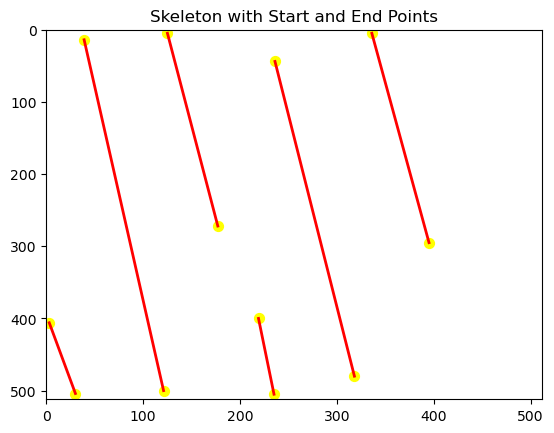

In [22]:
line_coordinates = []
    
for label in range(1, num_labels + 1):
    component_mask = (labeled_skeleton == label)
    endpoints = []
    
    # Loop through skeleton and find endpoints
    for y in range(1, component_mask.shape[0] - 1):
        for x in range(1, component_mask.shape[1] - 1):
            if component_mask[y, x]:
                # Check the 8-neighborhood
                neighbors = component_mask[y-1:y+2, x-1:x+2]
                if np.sum(neighbors) == 2:  # Exactly one neighbor means it's an endpoint
                    endpoints.append((x, y))

    if len(endpoints) == 2:
        start = endpoints[0]
        end = endpoints[1]
        line_coordinates.append([start[0], start[1], end[0], end[1]])

print(line_coordinates)

for line in line_coordinates:
    plt.plot([line[0], line[2]], [line[1], line[3]], 'r-', linewidth=2)  # Red line between start and end
    plt.scatter([line[0], line[2]], [line[1], line[3]], c='yellow', s=50)  # Yellow dots for the points

plt.ylim(0, skeleton.shape[0])
plt.xlim(0, skeleton.shape[0])

plt.gca().invert_yaxis()

plt.title("Skeleton with Start and End Points")
plt.show()

In [23]:
def calculate_EA_matrix(pred_coords, gt_coords, size=(512, 512)):
    p_lines = []
    g_lines = []
    for points in pred_coords:
        if len(points) == 0:
            continue 
        if points[0] == points[2] and points[1] == points[3]:
            continue 
        else:
            p_lines.append(Line(list(points)))
    
    for points in gt_coords:
        if len(points) == 0:
            continue
        if points[0] == points[2] and points[1] == points[3]:
            continue 
        else:
            g_lines.append(Line(list(points)))
            
    rows = len(pred_coords)
    cols = len(gt_coords)
    
    EA_matrix = np.zeros((cols, cols))
    
    for i in range(rows):
        for j in range(cols):
            EA_matrix[i, j] = EA_metric(p_lines[i], g_lines[j], size)
    
    print("EA Distance Matrix:")
    print(EA_matrix)

In [31]:
ground_coord = [[0, 313.24078091106276, 462, 202], [0, 397.27898966704925, 450, 280], [0, 468.0588901472256, 488, 352],
[162.0754716981137, 512, 512, 424], [499.6282722513088, 512, 512, 508.80675675675684]]
calculate_EA_matrix(line_coordinates, ground_coord)

EA Distance Matrix:
[[0.70353658 0.6741139  0.48312519 0.24423843 0.03383942]
 [0.5168378  0.68199832 0.58127021 0.31199934 0.05336652]
 [0.44781753 0.69645722 0.88651747 0.57258305 0.1800939 ]
 [0.26221965 0.42824352 0.60035457 0.7858645  0.33117563]
 [0.         0.         0.         0.         0.        ]]


In [32]:
tp, fp, fn, avg_len_diff = calculate_tp_fp_fn(line_coordinates, ground_coord, 0.70)
print(tp)
print(fp)
print(fn)

3.0
1.0
2.0


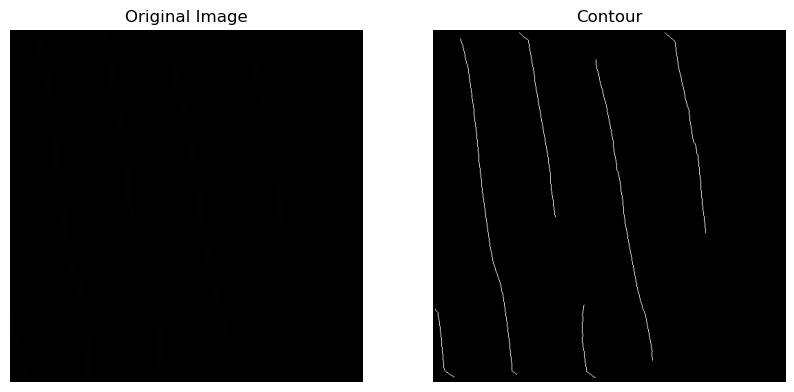

In [24]:
skeleton_uint8 = (skeleton * 255).astype(np.uint8)

plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(tile_uint8, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Edge-detected Image
plt.subplot(1, 2, 2)
plt.imshow(skeleton_uint8, cmap='gray')
plt.title('Contour')
plt.axis('off')

plt.show()

In [25]:
blank_image = np.zeros((512, 512), dtype=np.uint8)

for line in line_coordinates:
    x1, y1, x2, y2 = line
    cv2.line(blank_image, (int(x1), int(y1)), (int(x2), int(y2)), color=255, thickness=2)

meta.update(dtype=rasterio.uint8, height=blank_image.shape[0], width=blank_image.shape[1])

output_path = 'output_with_lines.tif'

# Write the blank image with lines to a new .tif file
with rasterio.open(output_path, 'w', **meta) as dst:
    dst.write(blank_image, 1)  # Write the modified image (with lines) to the first band
    dst.transform = transform  # Keep the same transform (if necessary)

In [26]:
file_path = 'output_with_lines.tif'

with rasterio.open(file_path) as src:
    image = src.read(1)
    meta = src.meta
    transform = src.transform

# Define a kernel
kernel = np.ones((15,15), np.uint8)

# Apply dilation
dilated_edges = cv2.dilate(image, kernel, iterations=1)

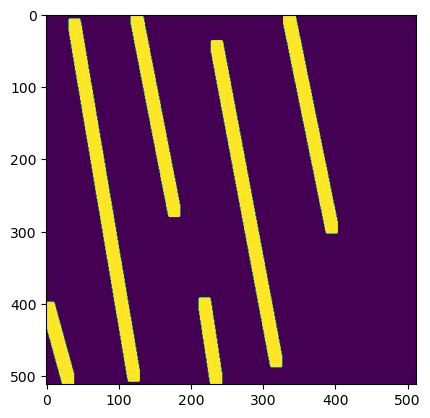

In [27]:
plt.imshow(dilated_edges)

In [30]:
ground_tile_path = os.path.join(curr_path, 'Data\Dataset\\test\\masks\mask_11_4608_4608.tif')

print(ground_tile_path)

D:\Masters\OVGU\VII_Semester\Thesis\jupyter_notebooks\Data\Dataset\test\masks\mask_11_4608_4608.tif


In [31]:
with rasterio.open(ground_tile_path) as src:
    ground_image = src.read(1)  # Read the first band (assuming grayscale)
    meta = src.meta  # Get the metadata for the image
    transform = src.transform  # Get the affine transform

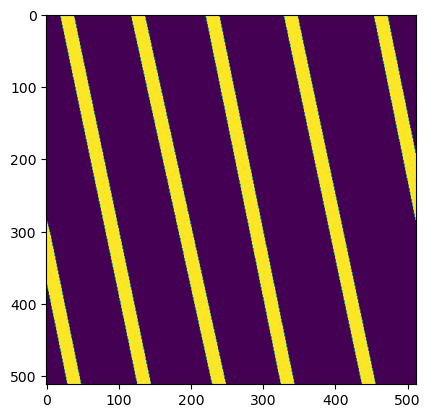

In [32]:
plt.imshow(ground_image)

In [33]:
ground_image

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [50]:
def calculate_iou_for_both_classes(ground_truth_mask, predicted_mask):
    """
    Calculate Intersection over Union (IoU) for both the background class (0) and the positive class (1)
    in binary segmentation masks.

    Args:
        ground_truth_mask (numpy array): Binary ground truth mask (2D array of 0s and 1s).
        predicted_mask (numpy array): Binary predicted mask (2D array of 0s and 1s).

    Returns:
        tuple: IoU score for the background class (0), IoU score for the positive class (1).
    """
    # Ensure both masks are binary (contain only 0s and 1s)
    ground_truth_mask = ground_truth_mask.astype(np.uint8)
    predicted_mask = predicted_mask.astype(np.uint8)

    # Calculate IoU for class 1 (positive class)
    intersection_1 = np.logical_and(ground_truth_mask == 1, predicted_mask == 1).sum()
    union_1 = np.logical_or(ground_truth_mask == 1, predicted_mask == 1).sum()

    iou_1 = intersection_1 / union_1 if union_1 != 0 else 0.0
    print(f"Class 1 (Positive): Intersection={intersection_1}, Union={union_1}, IoU={iou_1}")

    # Calculate IoU for class 0 (background class)
    intersection_0 = np.logical_and(ground_truth_mask == 0, predicted_mask == 0).sum()
    union_0 = np.logical_or(ground_truth_mask == 0, predicted_mask == 0).sum()

    iou_0 = intersection_0 / union_0 if union_0 != 0 else 0.0
    print(f"Class 0 (Background): Intersection={intersection_0}, Union={union_0}, IoU={iou_0}")

    return iou_0, iou_1


In [51]:
iou_score, iou_1 = calculate_iou_for_both_classes(ground_image, dilated_edges)
print(f"IoU Score: {iou_score}")
print(iou_1)

Class 1 (Positive): Intersection=0, Union=47472, IoU=0.0
Class 0 (Background): Intersection=204604, Union=237776, IoU=0.8604905457237063
IoU Score: 0.8604905457237063
0.0


In [47]:
contours, _ = cv2.findContours(dilated_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Step 2: Get bounding boxes for each contour
bounding_boxes = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)  # x, y are top-left coordinates, w is width, h is height
    bounding_boxes.append((x, y, x + w, y + h))  # Convert to (x1, y1, x2, y2) format

# Now `bounding_boxes` contains the bounding box coordinates for your dilated lines
print(bounding_boxes)

[(0, 398, 39, 512), (211, 392, 244, 512), (228, 36, 327, 489), (31, 6, 130, 509), (328, 0, 404, 304), (117, 0, 186, 281)]


In [62]:
ground_image = os.path.join(curr_path, 'Data\Dataset\\test\masks\mask_11_4224_3840.tif')

In [65]:
with rasterio.open(ground_image) as src:
    image = src.read(1)
    meta = src.meta
    transform = src.transform

image_uint8 = (image * 255).astype(np.uint8)

In [66]:
contours, _ = cv2.findContours(image_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Step 2: Get bounding boxes for each contour
ground_bounding_boxes = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)  # x, y are top-left coordinates, w is width, h is height
    ground_bounding_boxes.append((x, y, x + w, y + h))  # Convert to (x1, y1, x2, y2) format

# Now `bounding_boxes` contains the bounding box coordinates for your dilated lines
print(ground_bounding_boxes)

[(469, 500, 512, 512), (126, 417, 512, 512), (0, 345, 497, 484), (0, 273, 459, 407), (0, 195, 471, 327)]


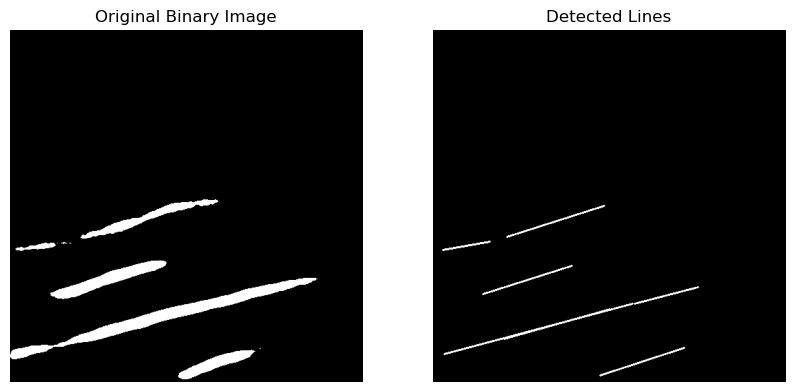

In [38]:
# Display the original binary image and the detected lines
plt.figure(figsize=(10, 5))

# Plot the original binary image
plt.subplot(1, 2, 1)
plt.imshow(tile_uint8, cmap='gray')
plt.title('Original Binary Image')
plt.axis('off')

# Plot the detected lines
plt.subplot(1, 2, 2)
plt.imshow(refined_blank, cmap='gray')
plt.title('Detected Lines')
plt.axis('off')

# Show the plots
plt.show()

In [39]:
ground_truth_coor_path = os.path.join(curr_path, 'Data\\Tile_Line_Coo_2\\output_3584_4608_coo.txt')

ground_truth_coor = []

with open(ground_truth_coor_path, 'r') as file:
    for line in file:
        line = line.strip()

        coordinates = [float(x) for x in line.split(',')]

        ground_truth_coor.append(coordinates)

print(ground_truth_coor)

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\Masters\\OVGU\\VII_Semester\\Thesis\\jupyter_notebooks\\Data\\Tile_Line_Coo_2\\output_3584_4608_coo.txt'

In [ ]:
refined_lines = refined_lines.reshape(-1, 4)

In [ ]:
print(refined_lines.shape)

In [40]:
tp, fp, fn, avg_len_diff = calculate_tp_fp_fn(refined_lines, ground_truth_coor, 0.80)

print('True_Positives', tp)
print('False Positives', fp)
print('False Negatives', fn)
print('Average Length Difference', avg_len_diff)

IndexError: index 2 is out of bounds for axis 0 with size 1

In [41]:
for i in range(4):
    x1, y1, x2, y2 = p[i].coord
    plt.plot([x1, x2], [y1, y2] , 'r-')

    x1, y1, x2, y2 = g[i].coord
    plt.plot([x1, x2], [y1, y2] , 'orange')

plt.gca().invert_yaxis()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

NameError: name 'p' is not defined

In [ ]:
print(type(p))

In [ ]:
print(avg_len)

In [ ]:
print(p)

In [ ]:
print(g)

In [42]:
import cv2
import numpy as np

def create_bounding_boxes(lines, image_shape, width=1):
    """
    Creates bounding boxes around lines in an image.

    Args:
        lines: A list of lines, each represented as a tuple (x1, y1, x2, y2).
        image_shape: The shape of the image (height, width).
        width: The desired width of the bounding boxes (applied perpendicular to the line).

    Returns:
        A list of bounding boxes, each represented as a tuple (x_min, y_min, x_max, y_max).
    """

    bounding_boxes = []
    half_width = width / 2

    for line in lines:
        x1, y1, x2, y2 = line
        dx = x2 - x1
        dy = y2 - y1

        # Normalize the direction of the line
        length = np.sqrt(dx**2 + dy**2)
        if length == 0:
            continue  # Skip degenerate lines

        # Unit vector perpendicular to the line (dy, -dx)
        perp_dx = -dy / length
        perp_dy = dx / length

        # Compute the four corners of the bounding box
        x1_bb_min = int(max(min(x1 + perp_dx * half_width, x1 - perp_dx * half_width), 0))
        y1_bb_min = int(max(min(y1 + perp_dy * half_width, y1 - perp_dy * half_width), 0))
        x2_bb_max = int(min(max(x2 + perp_dx * half_width, x2 - perp_dx * half_width), image_shape[1] - 1))
        y2_bb_max = int(min(max(y2 + perp_dy * half_width, y2 - perp_dy * half_width), image_shape[0] - 1))

        # Ensure proper bounding box ordering (x_min, y_min, x_max, y_max)
        x_min = min(x1_bb_min, x2_bb_max)
        y_min = min(y1_bb_min, y2_bb_max)
        x_max = max(x1_bb_min, x2_bb_max)
        y_max = max(y1_bb_min, y2_bb_max)

        bounding_boxes.append((x_min, y_min, x_max, y_max))

    return bounding_boxes


In [43]:
# Example usage:
image_shape = (512, 512)  # Replace with your actual image shape
#lines = [(100, 200, 300, 400), (200, 100, 400, 300)]  # Example lines
pred_bounding_boxes = create_bounding_boxes(line_coordinates, image_shape, width=2)
print(pred_bounding_boxes)

[(12, 248, 297, 320), (60, 337, 225, 384), (8, 360, 445, 480), (242, 461, 363, 502)]


In [44]:
ground_bounding_boxes = create_bounding_boxes(ground_coord, image_shape, width=2)
print(ground_bounding_boxes)

[(0, 202, 462, 312), (0, 280, 450, 396), (0, 352, 488, 467), (161, 424, 511, 511), (499, 509, 511, 511)]


In [45]:
from torchvision.ops import box_iou

In [48]:
ground_truth_boxes_tensor = torch.tensor(ground_bounding_boxes, dtype=torch.float)
predicted_boxes_tensor = torch.tensor(pred_bounding_boxes, dtype=torch.float)

In [49]:
iou_matrix = box_iou(predicted_boxes_tensor, ground_truth_boxes_tensor)

In [50]:
print("IoU matrix:")
print(iou_matrix)

IoU matrix:
tensor([[0.3435, 0.1859, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1486, 0.0901, 0.0000, 0.0000],
        [0.0000, 0.1769, 0.7566, 0.2374, 0.0000],
        [0.0000, 0.0000, 0.0120, 0.1629, 0.0000]])


In [82]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Create a blank black image
image_dummy = np.zeros((512, 512, 3), dtype=np.uint8)

In [87]:
def visualize_bounding_boxes_with_width(image, lines, width=10):
    """
    Visualizes bounding boxes around diagonal lanes on the given image with a specified width.

    Args:
        image: The image as a NumPy array (H, W, C).
        lines: A list of lines, each represented as (x1, y1, x2, y2).
        width: The width of the bounding box around the line.
    """
    image_copy = image.copy()
    bounding_boxes = []  # List to store bounding box coordinates

    for line in lines:
        # Get line coordinates
        x1, y1, x2, y2 = line
        dx = x2 - x1
        dy = y2 - y1
        line_length = np.sqrt(dx**2 + dy**2)
        
        # Normalize direction vectors (perpendicular to the line)
        perpendicular_dx = -dy / line_length * width / 2
        perpendicular_dy = dx / line_length * width / 2

        # Compute the 4 corners of the bounding box
        box = np.array([
            [x1 - perpendicular_dx, y1 - perpendicular_dy],
            [x1 + perpendicular_dx, y1 + perpendicular_dy],
            [x2 + perpendicular_dx, y2 + perpendicular_dy],
            [x2 - perpendicular_dx, y2 - perpendicular_dy]
        ], dtype=np.intp)

        bounding_boxes.append(box)  # Store the bounding box

        # Draw the bounding box
        cv2.polylines(image_copy, [box], isClosed=True, color=(0, 255, 0), thickness=2)  # Green for bounding box

    # Display the image with bounding boxes
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    # Print bounding boxes for further use
    print("Bounding boxes:", bounding_boxes)


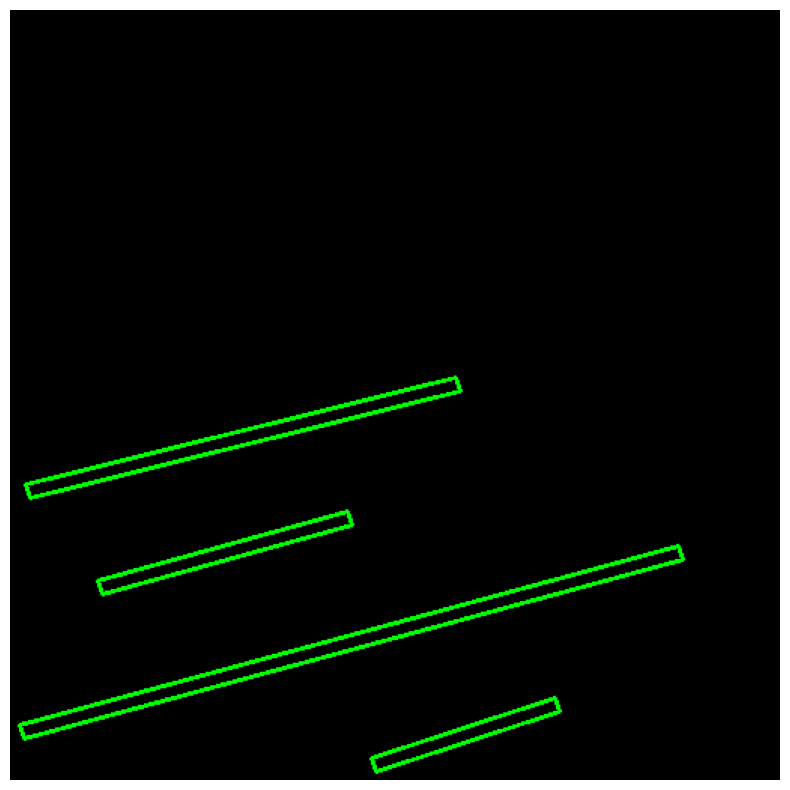

Bounding boxes: [array([[299, 253],
       [296, 244],
       [ 10, 315],
       [ 13, 324]], dtype=int64), array([[227, 342],
       [224, 333],
       [ 58, 379],
       [ 61, 388]], dtype=int64), array([[447, 365],
       [444, 356],
       [  6, 475],
       [  9, 484]], dtype=int64), array([[365, 466],
       [362, 457],
       [240, 497],
       [243, 506]], dtype=int64)]


In [88]:
# Call the function to visualize
visualize_bounding_boxes_with_width(image_dummy, line_coordinates)

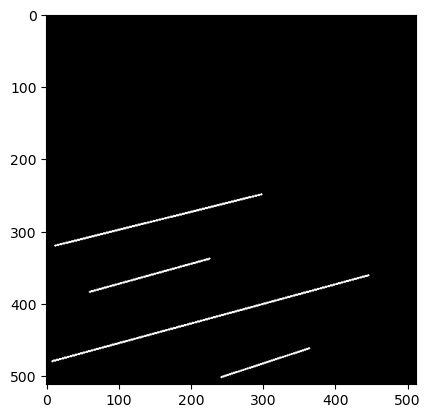

In [74]:
plt.imshow(image_dummy)

In [78]:
def extract_bounding_boxes(lines, width=10):
    bounding_boxes = []
    
    for line in lines:
        x1, y1, x2, y2 = line
        dx = x2 - x1
        dy = y2 - y1
        line_length = np.sqrt(dx**2 + dy**2)
        
        # Normalize direction vectors (perpendicular to the line)
        perpendicular_dx = -dy / line_length * width / 2
        perpendicular_dy = dx / line_length * width / 2

        # Compute the 4 corners of the bounding box
        box = np.array([
            [x1 - perpendicular_dx, y1 - perpendicular_dy],
            [x1 + perpendicular_dx, y1 + perpendicular_dy],
            [x2 + perpendicular_dx, y2 + perpendicular_dy],
            [x2 - perpendicular_dx, y2 - perpendicular_dy]
        ], dtype=np.int32)

        # Convert to (x1, y1, x2, y2) format
        x_min = int(min(box[:, 0]))
        y_min = int(min(box[:, 1]))
        x_max = int(max(box[:, 0]))
        y_max = int(max(box[:, 1]))
        
        bounding_boxes.append((x_min, y_min, x_max, y_max))

    return bounding_boxes

In [79]:
predicted_boxes = extract_bounding_boxes(line_coordinates, width = 15)

In [80]:
ground_boxes = extract_bounding_boxes(ground_coord, width = 15)

In [81]:
def plot_bounding_boxes(image, bounding_boxes):
    """
    Plots bounding boxes on the image.

    Args:
        image: The image as a NumPy array (H, W, C).
        bounding_boxes: A list of bounding boxes [(x1, y1, x2, y2), ...].
    """
    # Make a copy of the image for drawing
    image_copy = image.copy()

    # Draw each bounding box
    for box in bounding_boxes:
        x1, y1, x2, y2 = map(int, box)  # Convert to integer
        cv2.rectangle(image_copy, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2)

    # Display the image with bounding boxes
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
    plt.axis('off')  # Turn off axis labels
    plt.show()

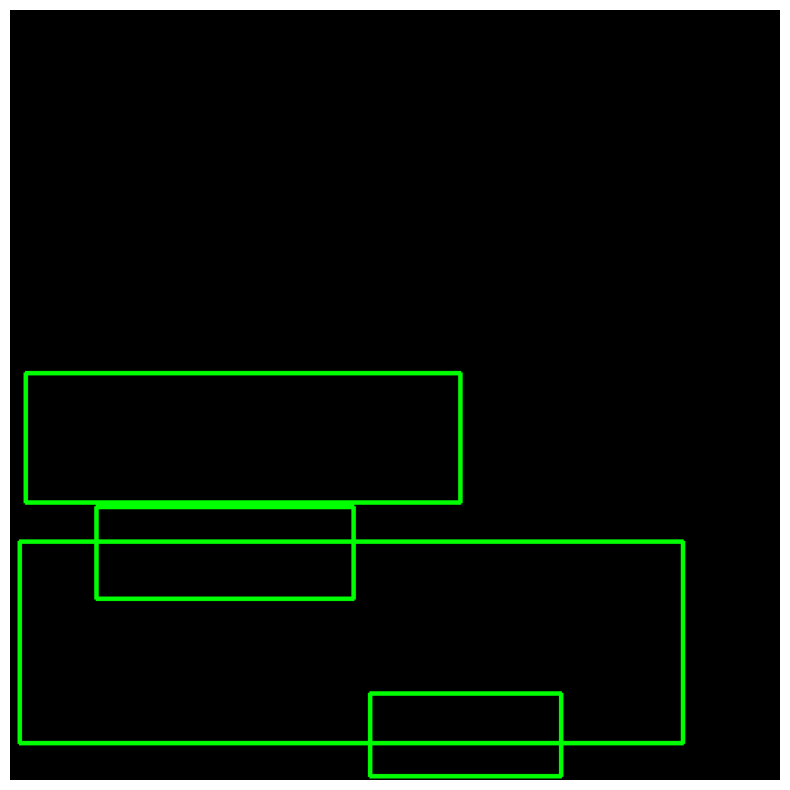

In [83]:
image_shape = (512, 512, 3)
blank_image = np.zeros(image_shape, dtype=np.uint8)

# Plot the bounding boxes on the blank image
plot_bounding_boxes(blank_image, predicted_boxes)

In [86]:
print(predicted_boxes)

[(10, 241, 299, 327), (57, 330, 228, 391), (6, 353, 447, 487), (239, 454, 366, 509)]


In [93]:
formatted_boxes = []

for box in bounding_boxes:
    # box should be a list or array of shape (4, 2)
    x_coords = [point[0] for point in box]  # Extract x coordinates
    y_coords = [point[1] for point in box]  # Extract y coordinates
    
    # Calculate the bounding box coordinates
    x1 = int(min(x_coords))
    y1 = int(min(y_coords))
    x2 = int(max(x_coords))
    y2 = int(max(y_coords))
    
    # Append to formatted_boxes
    formatted_boxes.append((x1, y1, x2, y2))  # Append as a tuple

TypeError: 'int' object is not subscriptable

In [92]:
bounding_boxes

[(234, 454, 373, 511),
 (0, 353, 455, 489),
 (52, 330, 235, 393),
 (4, 241, 307, 329)]